In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
import plotly.express as px
import os

import math
import re
from scipy import sparse
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import learning_curve, GridSearchCV

sns.set_style("darkgrid")
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [7]:
df_movie_titles=pd.read_csv("/Users/ruchimendhegiri/Desktop/STEVENS/Sem3/686/FinalProject/Collaborative/movie_titles.csv",encoding='latin1') 

In [8]:
df_movie_titles.head()

,ID,Year,Title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [9]:
# Merging Data

if not os.path.isfile('data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # reading from each of the four files and appending each rating to a global file 'train.csv'
    data = open('data.csv', mode='w')
    
    row = list()
    files=['/Users/ruchimendhegiri/Desktop/STEVENS/Sem3/686/FinalProject/Collaborative/combined_data_1.txt','/Users/ruchimendhegiri/Desktop/STEVENS/Sem3/686/FinalProject/Collaborative/combined_data_2.txt', 
           '/Users/ruchimendhegiri/Desktop/STEVENS/Sem3/686/FinalProject/Collaborative/combined_data_3.txt', '/Users/ruchimendhegiri/Desktop/STEVENS/Sem3/686/FinalProject/Collaborative/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:]
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()


In [10]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('data.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
#df.date = pd.to_datetime(df.date)
print('Done.\n')

# arranging the ratings according to time.
#print('Sorting the dataframe by date..')
#df.sort_values(by='date', inplace=True)
print('Done..')

creating the dataframe from data.csv file..
Done.

Done..


In [11]:
df.head()

,movie,user,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [12]:
df.describe()['rating']

count    7.915368e+07
mean     3.602359e+00
std      1.086446e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [13]:
df.isnull().sum()

movie     0
user      0
rating    0
date      0
dtype: int64

In [14]:
df.isnull().any()

movie     False
user      False
rating    False
date      False
dtype: bool

In [15]:
#Removing duplicate values
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


In [16]:
print("Dataset Statistics ")
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Dataset Statistics 

Total no of ratings : 79153679
Total No of Users   : 479635
Total No of movies  : 14317


In [17]:
#Splitting data into train data 80% and test data20%
if not os.path.isfile('train.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

In [18]:
print("Training data ")
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))
print("-"*50)
print("Test data ")
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Training data 

Total no of ratings : 63322943
Total No of Users   : 478893
Total No of movies  : 11521
--------------------------------------------------
Test data 

Total no of ratings : 15830736
Total No of Users   : 470994
Total No of movies  : 2797


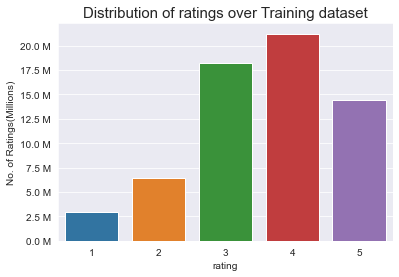

In [19]:
# Distribution of Ratings: Exploratory Data Analysis

# method to make y-axis more readable
def adjust(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"
    
# Display rating distribution plot  
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([adjust(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()


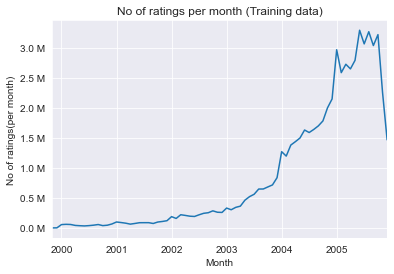

In [20]:
# Number of Ratings Per Month
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([adjust(item, 'M') for item in ax.get_yticks()])
plt.show()

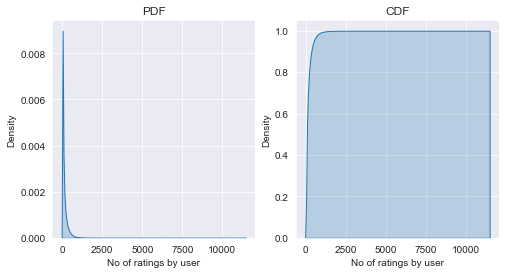

In [21]:
# Analysis of Number of ratings given by each user

no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

# Plot graph
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

In [22]:
no_of_rated_movies_per_user.describe()


count    478893.000000
mean        132.227748
std         193.766642
min           1.000000
25%          23.000000
50%          60.000000
75%         164.000000
max       11447.000000
Name: rating, dtype: float64

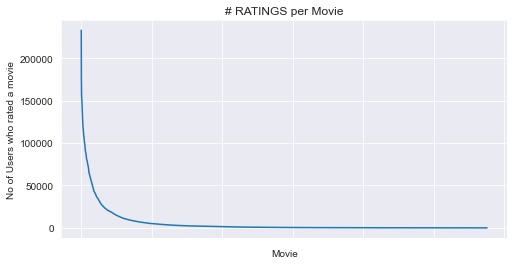

In [23]:
# Analysis of ratings of movie given by user

no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

# Cosine Based Collaborative filtering

In [29]:
# Use cosine Distance
ratings_cos = df[['user', 'movie', 'rating', 'date']][:10000]
ratings1=ratings_cos.copy()
col = ['movie', 'user']

In [30]:
ratings_cos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   user    10000 non-null  int64 
 1   movie   10000 non-null  int64 
 2   rating  10000 non-null  int64 
 3   date    10000 non-null  object
dtypes: int64(3), object(1)
memory usage: 312.6+ KB


In [31]:
for c in col:
    ratings_cos[c].replace({val: i for i, val in enumerate(ratings_cos[c].unique())}, inplace=True)

In [32]:
n_users=int(ratings_cos.user.nunique())
n_items=int(ratings_cos.movie.nunique())
print("n_users = ",n_users, "||", "n_items = ", n_items )

n_users =  9627 || n_items =  8


In [33]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(ratings_cos, test_size=0.20)

In [34]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]
    
test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [35]:
def predict(ratings1, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings1.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings1 - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings1.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [36]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [37]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

In [38]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def mse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_squared_error(prediction, ground_truth)

In [39]:
print('User-based CF MSE: ' , str(mse(user_prediction, test_data_matrix)))
print('Movie-based CF MSE: ' , str(mse(item_prediction, test_data_matrix)))

User-based CF MSE:  10.352947424711154
Movie-based CF MSE:  13.03242313657139


# Use of surprise package for collaborative filtering

In [40]:
#!pip install surprise

In [41]:
from surprise import Reader, Dataset, SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise.model_selection import cross_validate
#from surprise import GridSearch

In [42]:
# Define the format
reader = Reader()
ratings_dict = {'userID': list(df.user),'itemID': list(df.movie),'rating': list(df.rating)}
df1= pd.DataFrame(ratings_dict)


In [43]:
# As we have around 500k users datasets working with whole dataset is time consuming. Hence, for calculation purposes we will build model with only top 100k users
# get just top 10K rows for faster run time

ratings=df1[:10000]

In [44]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   userID  10000 non-null  int64
 1   itemID  10000 non-null  int64
 2   rating  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [54]:
#Find the rating range
Lower_rating = ratings['rating'].min()
Upper_rating = ratings['rating'].max()
print(Lower_rating,Upper_rating)

1 5


In [45]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1.0, 5.0))
# The columns must correspond to user id, item id and ratings (in that order)(Requirement by surprise package)
data = Dataset.load_from_df(ratings[['userID', 'itemID', 'rating']], reader)

In [46]:
# Use the famous SVD algorithm
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2403  1.2172  1.2246  1.2442  1.2240  1.2301  0.0104  
MAE (testset)     1.0157  1.0040  1.0047  1.0169  1.0094  1.0101  0.0054  
Fit time          1.37    0.75    0.69    0.87    1.23    0.98    0.27    
Test time         0.05    0.01    0.03    0.02    0.02    0.03    0.01    


{'test_rmse': array([1.24032304, 1.21716864, 1.22457014, 1.24421859, 1.22403642]),
 'test_mae': array([1.01571797, 1.00400897, 1.00472612, 1.0168727 , 1.00941359]),
 'fit_time': (1.3689582347869873,
  0.7488789558410645,
  0.6871378421783447,
  0.8729000091552734,
  1.229269027709961),
 'test_time': (0.052973270416259766,
  0.013321876525878906,
  0.025040149688720703,
  0.01726508140563965,
  0.0172731876373291)}

In [47]:
# Use KNN algorithm
from surprise import KNNBasic

algo = KNNBasic()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2593  1.2456  1.2664  1.2677  1.2788  1.2635  0.0109  
MAE (testset)     1.0684  1.0494  1.0795  1.0679  1.0852  1.0701  0.0123  
Fit time          6.31    5.67    6.03    4.68    3.95    5.33    0.88    
Test time         0.30    0.22    0.20    0.21    0.19    0.22    0.04    


{'test_rmse': array([1.25925609, 1.2456307 , 1.26638725, 1.26766464, 1.27877512]),
 'test_mae': array([1.0683509 , 1.04937102, 1.07949754, 1.06788763, 1.08518611]),
 'fit_time': (6.308780193328857,
  5.666879892349243,
  6.027103900909424,
  4.679332971572876,
  3.9499597549438477),
 'test_time': (0.29703187942504883,
  0.22275710105895996,
  0.2039802074432373,
  0.20731806755065918,
  0.18809199333190918)}

In [48]:
# Use NMF algorithm
from surprise import NMF
algo = NMF()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2597  1.3038  1.2516  1.2871  1.2927  1.2790  0.0200  
MAE (testset)     1.0600  1.0975  1.0504  1.0829  1.0890  1.0760  0.0178  
Fit time          1.39    1.46    1.42    1.34    1.36    1.39    0.04    
Test time         0.03    0.02    0.01    0.02    0.01    0.02    0.01    


{'test_rmse': array([1.25973455, 1.30380379, 1.2515941 , 1.28714647, 1.29273227]),
 'test_mae': array([1.06004602, 1.09753275, 1.05035155, 1.08286646, 1.0889838 ]),
 'fit_time': (1.388051986694336,
  1.4618349075317383,
  1.4152939319610596,
  1.3398351669311523,
  1.3616199493408203),
 'test_time': (0.03053116798400879,
  0.02251291275024414,
  0.01427912712097168,
  0.017908811569213867,
  0.012700796127319336)}

# Plot Comparision

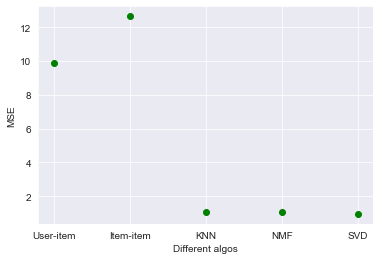

In [49]:
import matplotlib.pyplot as plt
mses = [9.9, 12.65, 1.07, 1.06, 0.95]
algos = ['User-item','Item-item', 'KNN', 'NMF', 'SVD']
plt.plot(algos, mses, 'go',  )
plt.xlabel("Different algos")
plt.ylabel("MSE")
plt.show()

# Predict Movie based on SVD Algorithm


In [61]:
# get list of all movie ids
iid=ratings['itemID'].unique()
# get list of all user ids
uid=ratings['userID'].unique()

In [71]:
from collections import defaultdict

def get_top_n(predictions, n=5):
# First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n
# First train an SVD algorithm on the Netflix dataset.
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

#  predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=5)

user_ratings = top_n.get(30878)
print("30878", [iid for (iid, _) in user_ratings])



30878 [2, 3, 6, 4, 8]
